# IMPORT PACKAGE LIBRARY

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# LOAD DATASET SAHAM

In [2]:
df = pd.read_csv("BBNI.JK.csv")
df.head()

,web_scraper_order,web_scraper_start_url,date,open,high,low,close_close_price_adjusted_for_splits,adj_close_adjusted_close_price_adjusted_for_splits_and_dividend_andor_capital_gain_distributions,volume
0,1765972550-1,https://finance.yahoo.com/quote/BBNI.JK/histor...,"Dec 17, 2025","4,400.00","4,420.00","4,340.00","4,370.00","4,370.00","27,653,900"
1,1765972550-2,https://finance.yahoo.com/quote/BBNI.JK/histor...,"Dec 16, 2025","4,440.00","4,460.00","4,330.00","4,400.00","4,400.00","36,287,500"
2,1765972550-3,https://finance.yahoo.com/quote/BBNI.JK/histor...,"Dec 15, 2025","4,270.00","4,450.00","4,230.00","4,440.00","4,440.00","57,531,500"
3,1765972550-4,https://finance.yahoo.com/quote/BBNI.JK/histor...,"Dec 12, 2025","4,290.00","4,290.00","4,170.00","4,240.00","4,240.00","23,240,100"
4,1765972550-5,https://finance.yahoo.com/quote/BBNI.JK/histor...,"Dec 11, 2025","4,350.00","4,390.00","4,190.00","4,230.00","4,230.00","43,389,300"


**PASTIKAN NAMA KOLOM**

In [ ]:
df.columns = [c.strip() for c in df.columns]

date_col = [c for c in df.columns if c.lower() == "date"][0]

# Dynamically find the price column (close / close price / adj close)
price_candidates = [c for c in df.columns if "close" in c.lower()]
if not price_candidates:
    raise ValueError("Kolom harga (close) tidak ditemukan")
price_col = price_candidates[0]

df[date_col] = pd.to_datetime(df[date_col], format='%b %d, %Y', errors='coerce')
df[price_col] = pd.to_numeric(df[price_col].astype(str).str.replace(',', ''), errors="coerce")

df = df.dropna(subset=[date_col, price_col]).sort_values(date_col).reset_index(drop=True)

# LOAD DATASET BI RATE

In [4]:
df2 = pd.read_excel("BI-7Day-RR.xlsx")
df2.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,NaN,NaN,NaN,NaN
1,BI-7Day-RR,BI-7Day-RR,BI-7Day-RR,BI-7Day-RR
2,NaN,NaN,NaN,NaN
3,NO,Tanggal,BI-7Day-RR,NaN
4,1,17 Desember 2025,4.75 %,NaN


**ambil baris dan kolom relevan**

In [5]:
df2 = df2.iloc[4:, :3].reset_index(drop=True)
df2.columns = ["no", "tanggal", "bi_rate"]

# Map Indonesian month names to English
indo_month_map = {
    'Januari': 'January', 'Februari': 'February', 'Maret': 'March',
    'April': 'April', 'Mei': 'May', 'Juni': 'June', 'Juli': 'July',
    'Agustus': 'August', 'September': 'September', 'Oktober': 'October',
    'November': 'November', 'Desember': 'December'
}

df2["tanggal"] = df2["tanggal"].replace(indo_month_map, regex=True)
df2["tanggal"] = pd.to_datetime(df2["tanggal"], dayfirst=True)
df2["bi_rate"] = (
    df2["bi_rate"].astype(str)
    .str.replace("%", "")
    .astype(float) / 100
)

df2 = df2.dropna().sort_values("tanggal", ascending=False)

r = df2.head(12)["bi_rate"].mean()
dt = 1 / 252

# SPLIT 12 BULAN(TRAIN) DAN 6 BULAN(TEST)

In [6]:
start_date = df[date_col].min()
cutoff_12m = start_date + pd.DateOffset(months=12)
cutoff_18m = cutoff_12m + pd.DateOffset(months=6)

df_train = df[df[date_col] < cutoff_12m].copy()
df_test  = df[(df[date_col] >= cutoff_12m) & (df[date_col] < cutoff_18m)].copy()


# ESTIMASI σ & S0

In [7]:
start_date = df[date_col].min()
cutoff_date = start_date + pd.DateOffset(months=12)
df_12m = df[df[date_col] < cutoff_date].copy()

log_ret = np.log(df_12m[price_col] / df_12m[price_col].shift(1)).dropna()
sigma_daily = log_ret.std()
sigma = sigma_daily * np.sqrt(252)

S0 = df_12m[price_col].iloc[-1]

# PARAMETER BINOMIAL

**CRR**

In [8]:
u_crr = np.exp(sigma * np.sqrt(dt))
d_crr = 1 / u_crr
p_crr = (np.exp(r * dt) - d_crr) / (u_crr - d_crr)

print("u_crr:", u_crr)
print("d_crr:", d_crr)
print("p_crr:", p_crr)

u_crr: 1.0240284094713712
d_crr: 0.9765354073684585
p_crr: 0.4984686903692023


**EMPIRIS**

In [9]:
f = df_train[price_col] / df_train[price_col].shift(1)
f = f.dropna()

u_emp = f[f >= 1].mean()
d_emp = f[f < 1].mean()
p_emp = (f >= 1).mean()

print("u_emp:", u_emp)
print("d_emp:", d_emp)
print("p_emp:", p_emp)


u_emp: 1.0171871217360668
d_emp: 0.9824928110628165
p_emp: 0.5127118644067796


# POHON BINOMIAL

In [10]:
def binomial_tree(S0, u, d, n):
    tree = np.zeros((n+1, n+1))
    for i in range(n+1):
        for j in range(i+1):
            tree[j, i] = S0 * (u**(i-j)) * (d**j)
    return tree


# MONTE CARLO BINOMIAL

In [11]:
def mc_binomial(S0, u, d, p, N, M=20000):
    rng = np.random.default_rng(42)
    mean, low, high = [], [], []

    for n in range(1, N+1):
        x = rng.binomial(n, p, M)
        S = S0 * (u**x) * (d**(n-x))
        mean.append(S.mean())
        lo, hi = np.quantile(S, [0.025, 0.975])
        low.append(lo)
        high.append(hi)

    return pd.DataFrame({
        "mean": mean,
        "low": low,
        "high": high
    })


**menentukan jumlah periode simulasi dan menjalankan simulasi Monte Carlo binomial untuk model CRR dan EMP berdasarkan data uji**

In [12]:
N = len(df_test)
mc_crr = mc_binomial(S0, u_crr, d_crr, p_crr, N)
mc_emp = mc_binomial(S0, u_emp, d_emp, p_emp, N)

**menghitung error prediksi (MAE, MSE, dan MAPE) antara data aktual dan hasil prediksi Monte Carlo untuk model CRR dan EMP**

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

real = df_test[price_col].values

def calculate_errors(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return {"MAE": mae, "MSE": mse, "MAPE": mape}

err_crr = calculate_errors(real, mc_crr["mean"])
err_emp = calculate_errors(real, mc_emp["mean"])

**Menyusun dan menampilkan hasil simulasi Monte Carlo (mean dan interval kepercayaan 95%)**


In [14]:
df_mc = pd.DataFrame({
    "Hari": np.arange(1, N + 1),

    "CRR_Mean": mc_crr["mean"].values,
    "CRR_Low_95": mc_crr["low"].values,
    "CRR_High_95": mc_crr["high"].values,

    "EMP_Mean": mc_emp["mean"].values,
    "EMP_Low_95": mc_emp["low"].values,
    "EMP_High_95": mc_emp["high"].values,
})

display(df_mc.head(10))


,Hari,CRR_Mean,CRR_Low_95,CRR_High_95,EMP_Mean,EMP_Low_95,EMP_High_95
0,1,4301.406215,4199.102252,4403.322161,4301.027489,4224.719088,4373.904623
1,2,4302.648915,4100.572028,4509.126989,4302.015143,4150.756132,4449.079455
2,3,4302.740039,4004.353776,4617.474138,4303.392578,4078.088060,4525.546325
3,4,4305.038579,3910.393246,4728.424698,4303.665157,4006.692202,4603.327440
4,5,4303.628122,3818.637461,4842.041222,4306.698286,3936.546285,4682.445390
5,6,4306.356732,3910.393246,4728.424698,4306.294716,4004.204185,4600.468933
6,7,4303.246978,3818.637461,4842.041222,4310.228068,3934.101826,4679.537753
7,8,4309.874083,3729.034689,4958.387772,4308.090159,3865.226762,4759.965538
8,9,4306.616340,3818.637461,4842.041222,4311.927287,3931.658885,4676.631922
9,10,4307.813263,3729.034689,4958.387772,4312.897819,3862.826590,4757.009764


# VISUALISASI

**PLOT PERBANDINGAN**

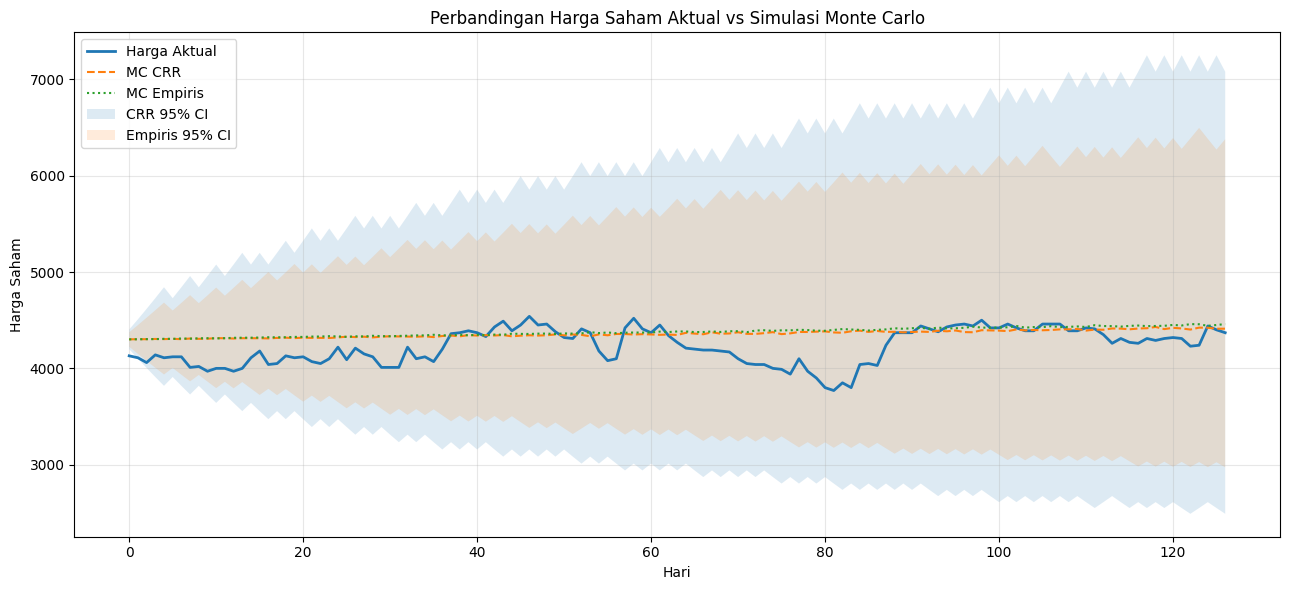

In [ ]:
    plt.figure(figsize=(13,6))
    plt.plot(range(N), df_test[price_col],
            label="Harga Aktual", linewidth=2)

    plt.plot(range(N), mc_crr["mean"],
            label="MC CRR", linestyle="--")

    plt.plot(range(N), mc_emp["mean"],
            label="MC Empiris", linestyle=":")

    plt.fill_between(range(N),
                    mc_crr["low"],
                    mc_crr["high"],
                    alpha=0.15, label="CRR 95% CI")

    plt.fill_between(range(N),
                    mc_emp["low"],
                    mc_emp["high"],
                    alpha=0.15, label="Empiris 95% CI")

    plt.title("Perbandingan Harga Saham Aktual vs Simulasi Monte Carlo")
    plt.xlabel("Hari")
    plt.ylabel("Harga Saham")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

**HARGA AKTUAL VS CRR**

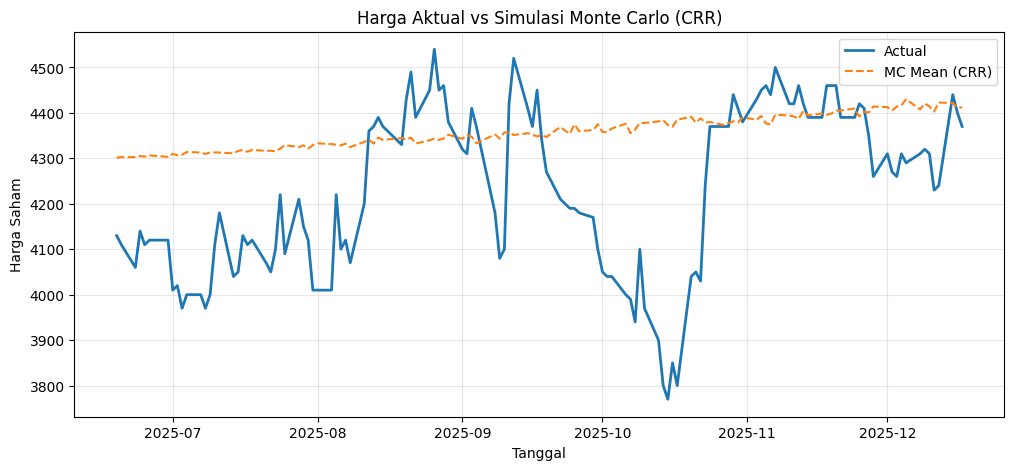

In [16]:
# Ensure actual dates and prices are aligned with the simulation length N
actual_dates_prices_for_plot = df_test[[date_col, price_col]].head(N).reset_index(drop=True)

comp_crr = pd.DataFrame({
    "date": actual_dates_prices_for_plot[date_col],
    "actual": actual_dates_prices_for_plot[price_col],
    "pred_mean_crr": mc_crr["mean"]
})

plt.figure(figsize=(12,5))
plt.plot(comp_crr["date"], comp_crr["actual"], label="Actual", linewidth=2)
plt.plot(comp_crr["date"], comp_crr["pred_mean_crr"], label="MC Mean (CRR)", linestyle="--")

plt.title("Harga Aktual vs Simulasi Monte Carlo (CRR)")
plt.xlabel("Tanggal")
plt.ylabel("Harga Saham")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

**HARGA AKTUAL VS EMPIRIS**

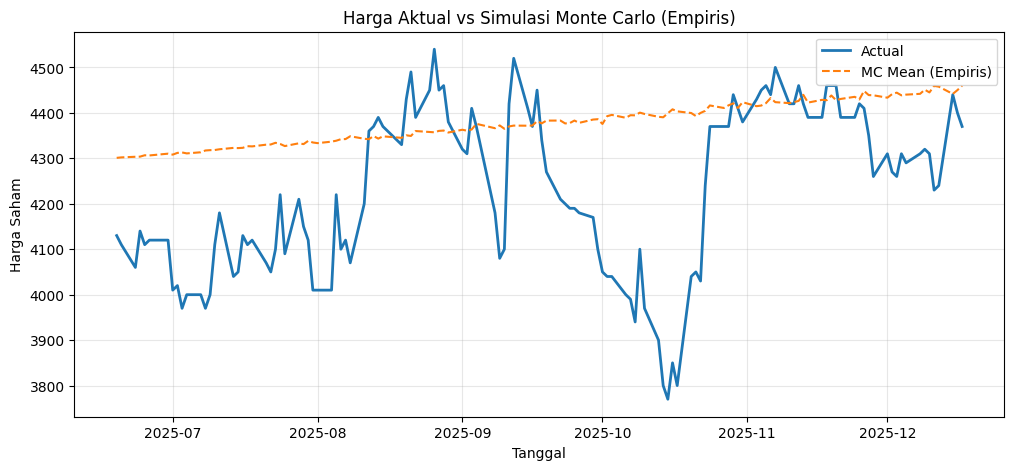

In [17]:
actual_dates_prices_for_plot = df_test[[date_col, price_col]].head(N).reset_index(drop=True)

comp_emp = pd.DataFrame({
    "date": actual_dates_prices_for_plot[date_col],
    "actual": actual_dates_prices_for_plot[price_col],
    "pred_mean_emp": mc_emp["mean"]
})

# A. Plot harga aktual vs simulasi Empiris
plt.figure(figsize=(12,5))
plt.plot(comp_emp["date"], comp_emp["actual"], label="Actual", linewidth=2)
plt.plot(comp_emp["date"], comp_emp["pred_mean_emp"], label="MC Mean (Empiris)", linestyle="--")

plt.title("Harga Aktual vs Simulasi Monte Carlo (Empiris)")
plt.xlabel("Tanggal")
plt.ylabel("Harga Saham")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

**EVALUASI HASIL DAN ERROR**

In [18]:
df_error = pd.DataFrame({
    "Model": ["CRR", "Empiris"],
    "MAE":  [err_crr["MAE"],  err_emp["MAE"]],
    "MSE":  [err_crr["MSE"],  err_emp["MSE"]],
    "MAPE (%)": [err_crr["MAPE"], err_emp["MAPE"]]
})

# Biar rapi
df_error = df_error.set_index("Model").round(4)

print("Tabel Perbandingan Error Model")
display(df_error)

Tabel Perbandingan Error Model


,MAE,MSE,MAPE (%)
Model,,,
CRR,168.0415,46353.4992,4.1102
Empiris,174.7564,50570.9010,4.2783


**ERROR MUTLAK**

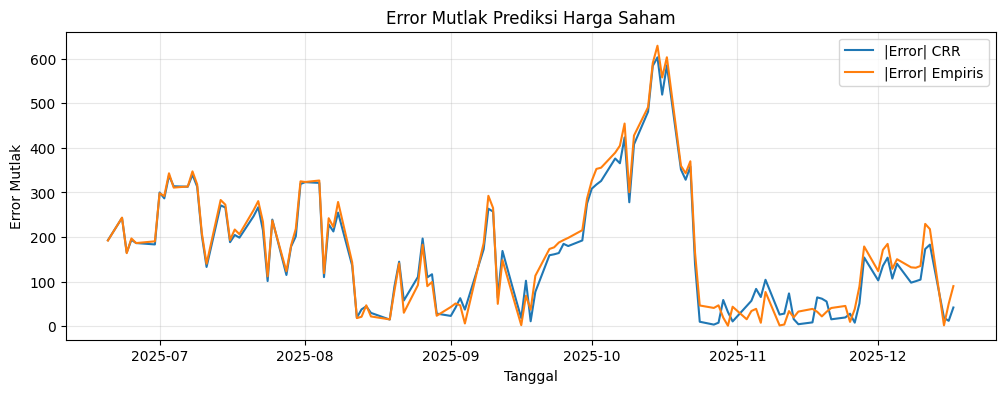

In [19]:
comp_crr["abs_error_crr"] = np.abs(comp_crr["actual"] - comp_crr["pred_mean_crr"])
comp_emp["abs_error_emp"] = np.abs(comp_emp["actual"] - comp_emp["pred_mean_emp"])

plt.figure(figsize=(12,4))
plt.plot(comp_crr["date"][1:], comp_crr["abs_error_crr"][1:], label="|Error| CRR")
plt.plot(comp_emp["date"][1:], comp_emp["abs_error_emp"][1:], label="|Error| Empiris")

plt.title("Error Mutlak Prediksi Harga Saham")
plt.xlabel("Tanggal")
plt.ylabel("Error Mutlak")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

**BOXPLOT ERROR**

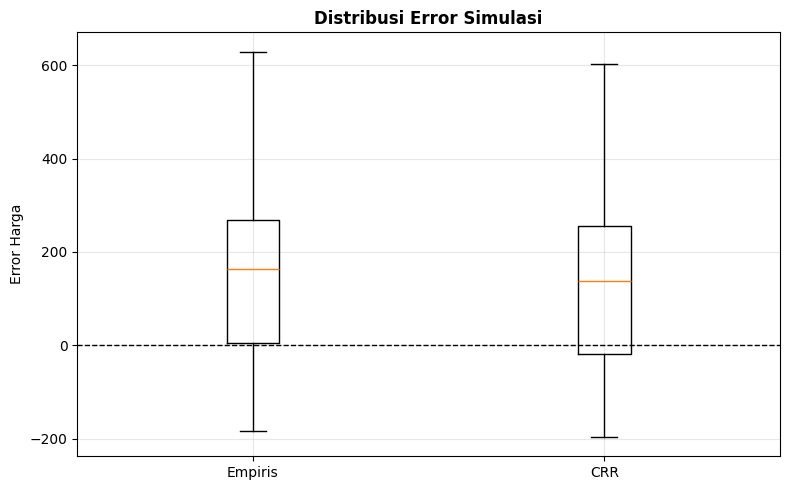

In [20]:
error_emp = mc_emp["mean"] - real
error_crr = mc_crr["mean"] - real

plt.figure(figsize=(8,5))
plt.boxplot([error_emp, error_crr], tick_labels=["Empiris", "CRR"])
plt.axhline(0, color="black", linestyle="--", linewidth=1)

plt.title("Distribusi Error Simulasi", fontweight="bold")
plt.ylabel("Error Harga")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**HISTOGRAM ERROR**

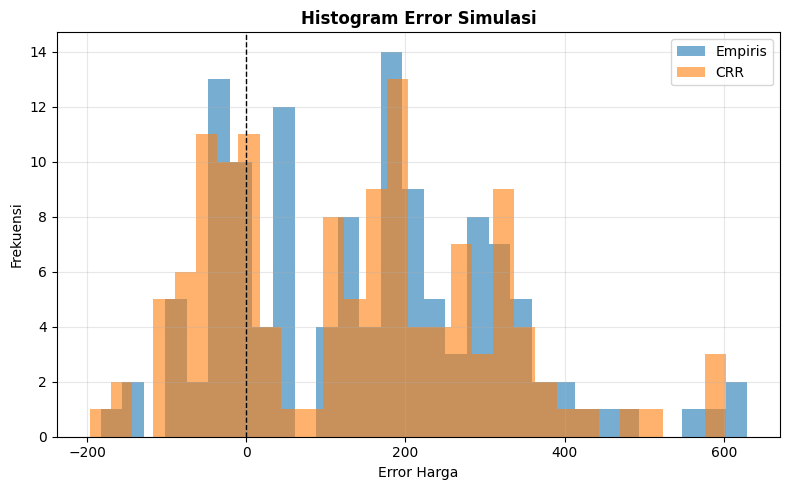

In [21]:
plt.figure(figsize=(8,5))
plt.hist(error_emp, bins=30, alpha=0.6, label="Empiris")
plt.hist(error_crr, bins=30, alpha=0.6, label="CRR")

plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.legend()
plt.title("Histogram Error Simulasi", fontweight="bold")
plt.xlabel("Error Harga")
plt.ylabel("Frekuensi")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
